In [2]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

from portfolio_factor_allocation.backtesting import bootstrap_studentized_sharpe_diff
from portfolio_factor_allocation.plotting import plot_sr_diff_and_pvalues

In [3]:
data_dir = Path.cwd().parent / "data"
returns_dir = data_dir / "active_returns"
summary_dir = data_dir / "active_summary"
bootstrap_dir = data_dir / "active_bootstrap"
# returns_dir = data_dir / "returns"
# summary_dir = data_dir / "summary"
# bootstrap_dir = data_dir / "bootstrap"
studentized_dir = bootstrap_dir / "studentized" / "sharpe"

studentized_dir.mkdir(parents=True, exist_ok=True)

### Load Data

In [4]:
df_market = pd.read_csv(data_dir / "returns" / "market.csv", parse_dates=["date"])
df_market["date"] = df_market["date"].dt.to_period("M")
df_monthly_rf = pd.read_csv(data_dir / "monthly_rf.csv", parse_dates=["date"])
df_monthly_rf["date"] = df_monthly_rf["date"].dt.to_period("M")

market_series = df_market.set_index("date")["market"]
rf_series = df_monthly_rf.set_index("date")["rf"]

### Bootstrap Parameters

In [5]:
factors = ["V", "W", "C", "R", "L"]
factor_combs = [
    list(c)
    for r in range(2, len(factors) + 1)
    for c in itertools.combinations(factors, r)
]

In [6]:
portfolios = ["ter", "dec", "bw", "te"]
block_size = 5
n_sim = 1000
seed = 42

### Compute Studentized Statistics

In [7]:
for factor_comb in factor_combs:
    factor_str = "_".join(factor_comb)

    # Load strategy returns
    df_r = pd.read_csv(returns_dir / f"{factor_str}.csv")
    df_r["date"] = pd.to_datetime(df_r["date"]).dt.to_period("M")
    df_r = df_r.set_index("date")

    # Align with risk-free rate (and market, though not strictly needed for Sharpe diff unless we want to be consistent)
    common_index = df_r.index.intersection(market_series.index).intersection(
        rf_series.index
    )

    aligned_r = df_r.loc[common_index]
    aligned_rf = rf_series.loc[common_index]

    # Calculate Excess Returns
    excess_r = aligned_r.sub(aligned_rf, axis=0)

    results_data = {}

    for group in portfolios:
        col_int = f"{factor_str}_int_{group}"
        col_mix = f"{factor_str}_mix_{group}"

        r_i = excess_r[col_int]
        r_n = excess_r[col_mix]

        # Compute studentized statistics
        d_tilde_stars = bootstrap_studentized_sharpe_diff(
            r_i, r_n, block_size, n_sim, seed=seed
        )

        results_data[group] = d_tilde_stars

    df_results = pd.DataFrame(results_data)
    output_path = studentized_dir / f"{factor_str}.csv"
    df_results.to_csv(output_path, index=False)

### Hypothesis testing

In [8]:
# Load observed studentized statistics
df_studentized = pd.read_csv(summary_dir / "studentized.csv", index_col=0)

# Initialize DataFrames for p-values
df_p_values_raw = pd.DataFrame(
    index=df_studentized.index, columns=df_studentized.columns
)
df_p_values_adj = pd.DataFrame(
    index=df_studentized.index, columns=df_studentized.columns
)

# Iterate over each portfolio (row in df_studentized)
for portfolio in df_studentized.index:
    # Get observed stats for this portfolio
    # These are the t_hat_j
    t_obs_series = df_studentized.loc[portfolio]

    # We need to gather the bootstrap distributions for all hypotheses (factors) for this portfolio
    # t_boot_matrix will be shape (n_sim, n_hypotheses)
    t_boot_list = []
    valid_factors = []

    for factor in df_studentized.columns:
        # Load bootstrap distribution for this factor
        df_boot = pd.read_csv(studentized_dir / f"{factor}.csv")
        t_boot_list.append(df_boot[portfolio].values)
        valid_factors.append(factor)

    # Convert to matrix: (n_sim, n_hypotheses)
    t_boot_matrix = np.column_stack(t_boot_list)
    t_obs = t_obs_series[valid_factors].values
    n_hypotheses = len(valid_factors)
    n_sim = t_boot_matrix.shape[0]

    # --- 1. Raw P-Values (One-Sided: Int > Mix) ---
    # We test H0: Delta <= 0 vs H1: Delta > 0
    # We reject H0 if t_obs is large and positive.
    # p_value = Prob(d* >= t_obs)

    # Raw p-values
    raw_p = np.mean(t_boot_matrix >= t_obs, axis=0)

    df_p_values_raw.loc[portfolio, valid_factors] = raw_p

    # --- 2. Romano-Wolf Stepdown (One-Sided) ---
    # Order hypotheses by t_obs descending (largest t-stats are most significant)
    indices = np.argsort(t_obs)[::-1]  # Descending order

    sorted_t_obs = t_obs[indices]
    sorted_t_boot = t_boot_matrix[:, indices]

    adj_p_values = np.zeros(n_hypotheses)

    # Stepdown
    for j in range(n_hypotheses):
        # Hypotheses still active: from j to end
        # Max over active hypotheses for each bootstrap draw
        max_t_boot = np.max(sorted_t_boot[:, j:], axis=1)

        # Adjusted p-value for hypothesis j (which is the j-th largest t_obs)
        # Prob( max_t_boot >= t_obs[j] )
        p_val = np.mean(max_t_boot >= sorted_t_obs[j])

        adj_p_values[j] = p_val

    # Enforce monotonicity
    # p_adj[j] = max(p_adj[j], p_adj[j-1])
    for j in range(1, n_hypotheses):
        adj_p_values[j] = max(adj_p_values[j], adj_p_values[j - 1])

    # Map back to original order
    final_adj_p = np.zeros(n_hypotheses)
    final_adj_p[indices] = adj_p_values

    df_p_values_adj.loc[portfolio, valid_factors] = final_adj_p

# Save results
df_p_values_raw.to_csv(summary_dir / "p_values_raw.csv")
df_p_values_adj.to_csv(summary_dir / "p_values_adj.csv")

### Plotting

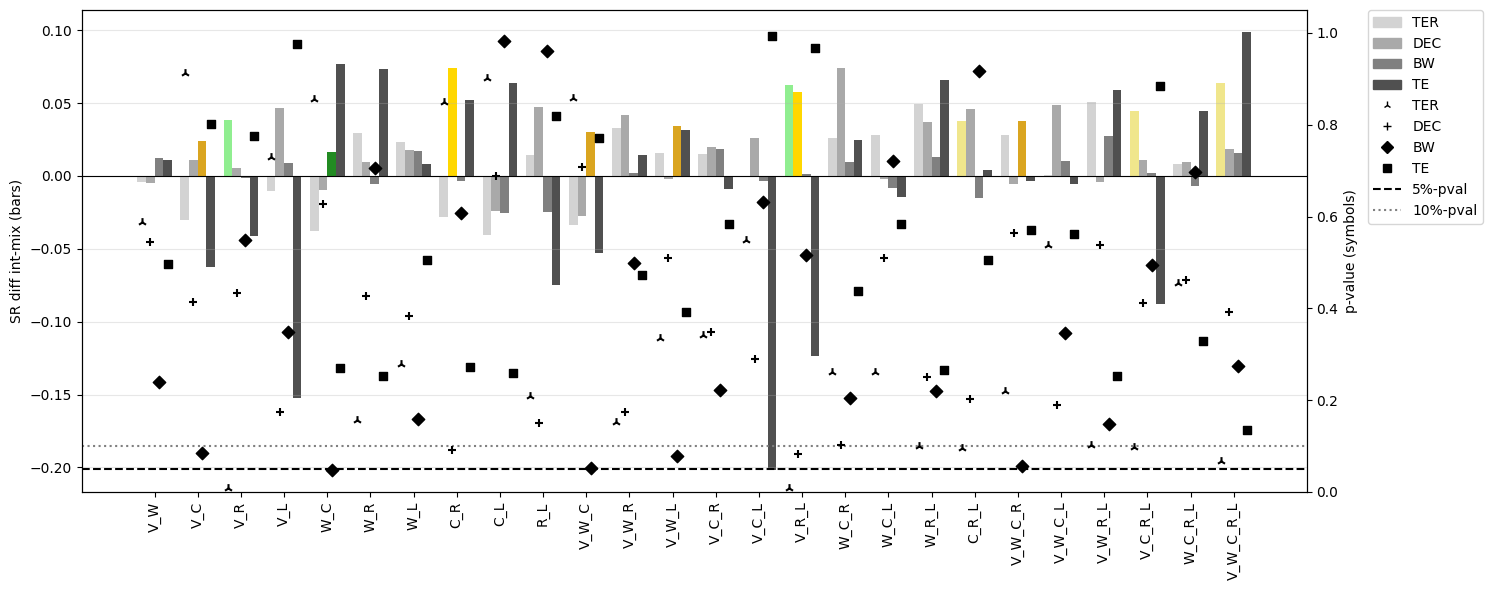

In [11]:
# Load data
df_sharpe = pd.read_csv(summary_dir / "sharpe_summary.csv", index_col=0)
df_p_values_raw = pd.read_csv(summary_dir / "p_values_raw.csv", index_col=0)

plot_sr_diff_and_pvalues(df_sharpe, df_p_values_raw, portfolios)

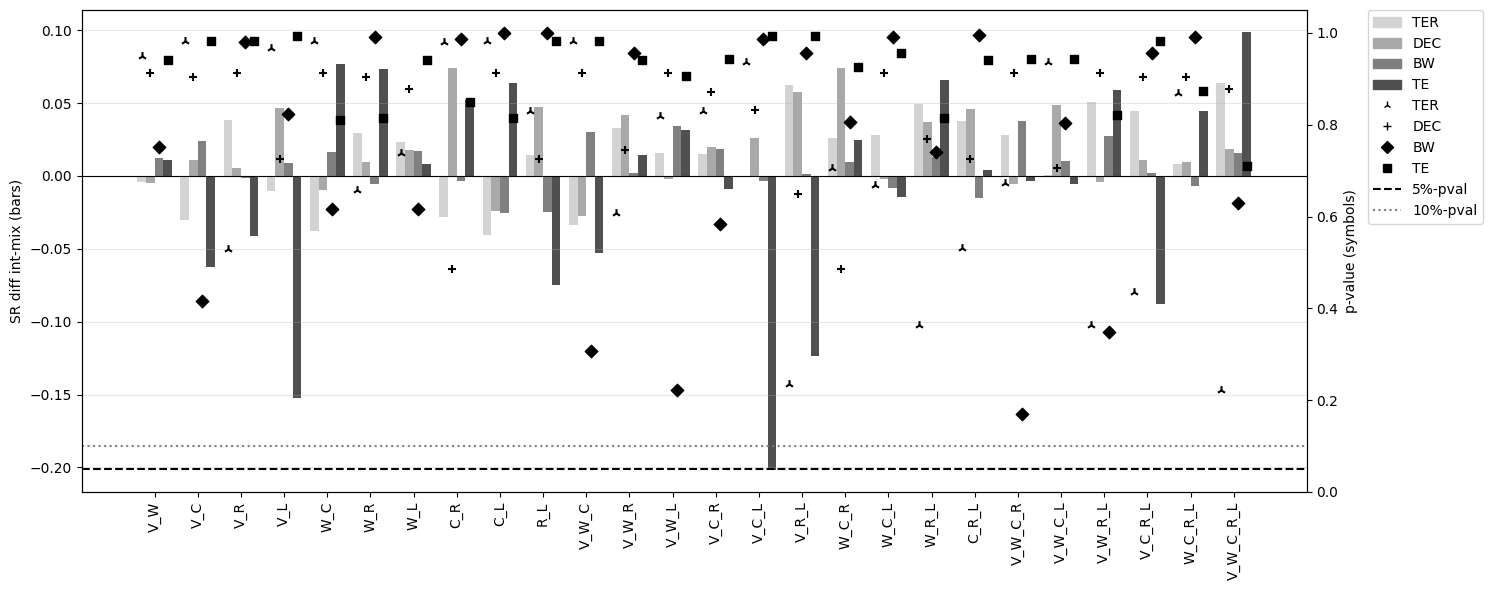

In [12]:
# Load data
df_sharpe = pd.read_csv(summary_dir / "sharpe_summary.csv", index_col=0)
df_p_values_adj = pd.read_csv(summary_dir / "p_values_adj.csv", index_col=0)

plot_sr_diff_and_pvalues(df_sharpe, df_p_values_adj, portfolios)